In [6]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_community.vectorstores import FAISS
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain.schema import Document
from dotenv import load_dotenv
load_dotenv()

True

In [30]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

llm = HuggingFaceEndpoint(
    repo_id="openai/gpt-oss-20b",
    task="text-generation"
)

model = ChatHuggingFace(llm=llm)

In [31]:
class AgentState(TypedDict):
    question: str
    documents: List[Document]
    answer: str
    needs_retrieval: bool

In [32]:
file_path = "../data/attention_is_all_you_need_Paper.pdf"
loader = PyPDFLoader(file_path)
documents= loader.load()


In [33]:
documents

[Document(metadata={'source': '../data/attention_is_all_you_need_Paper.pdf', 'page': 0}, page_content='Attention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser ∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and convolutions\nentirely. Experiments on two machine translation tasks 

In [34]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs = text_splitter.split_documents(documents)
vectorstore = FAISS.from_documents(docs, embeddings)


In [35]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
doc=retriever.invoke("What is attention mechanism?")

for d in doc:
    print(d.page_content)
    print("-----")

we found it beneﬁcial to linearly project the queries, keys and values htimes with different, learned
linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of
queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional
output values. These are concatenated and once again projected, resulting in the ﬁnal values, as
depicted in Figure 2.
Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this.
4To illustrate why the dot products get large, assume that the components of q and k are independent random
variables with mean 0 and variance 1. Then their dot product, q · k = ∑dk
i=1 qiki, has mean 0 and variance dk.
4
-----
convolution is equal to the combination of a self-attention layer and a point-wise feed-forward layer,
the approach we take in our model.
As side beneﬁt, self-

In [36]:

def decide_retrieval(state: AgentState) -> AgentState:

    question = state["question"]
    retrieval_keywords = ["what", "how", "explain", "describe", "tell me"]
    needs_retrieval = any(keyword in question.lower() for keyword in retrieval_keywords)
    
    return {**state, "needs_retrieval": needs_retrieval}

In [37]:
def retrieve_documents(state: AgentState) -> AgentState:
    question = state["question"]
    documents = retriever.invoke(question)
    
    return {**state, "documents": documents}

In [38]:
def generate_answer(state: AgentState) -> AgentState:

    question = state["question"]
    documents = state.get("documents", [])
    
    if documents:
        # RAG approach: use documents as context
        context = "\n\n".join([doc.page_content for doc in documents])
        prompt = f"""Based on the following context, answer the question:

                Context:
                {context}

                Question: {question}

                Answer:"""
        
    else:
        # Direct response without retrieval
        prompt = f"Answer the following question: {question}"
    
    response = model.invoke(prompt)
    answer = response.content
    
    return {**state, "answer": answer}

In [39]:
def should_retrieve(state: AgentState) -> str:

    if state["needs_retrieval"]:
        return "retrieve"
    else:
        return "generate"

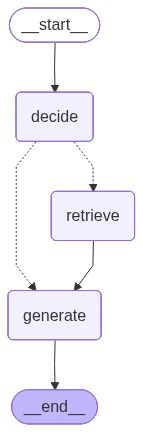

In [40]:

workflow = StateGraph(AgentState)


workflow.add_node("decide", decide_retrieval)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("generate", generate_answer)

workflow.set_entry_point("decide")


workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve": "retrieve",
        "generate": "generate"
    }
)


workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)


app = workflow.compile()
app

In [41]:
initial_state={
    "question": "What is the attention mechanism in transformers?",
    "documents": [],
    "answer": "",
    "needs_retrieval": False

}
response=app.invoke(initial_state)

In [42]:
response

{'question': 'What is the attention mechanism in transformers?',
 'documents': [Document(metadata={'source': '../data/attention_is_all_you_need_Paper.pdf', 'page': 1}, page_content='The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU\n[20], ByteNet [15] and ConvS2S [8], all of which use convolutional neural networks as basic building\nblock, computing hidden representations in parallel for all input and output positions. In these models,\nthe number of operations required to relate signals from two arbitrary input or output positions grows\nin the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes\nit more difﬁcult to learn dependencies between distant positions [ 11]. In the Transformer this is\nreduced to a constant number of operations, albeit at the cost of reduced effective resolution due\nto averaging attention-weighted positions, an effect we counteract with Multi-Head Attention as\ndescribed 